In [1]:

import sys
sys.path.append('..')

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

import pandas as pd
import numpy as np
import torch

In [7]:
pruning = "movement"

n_concepts = 4
n_atomics = 4
use_summaries_for_atomics = True
encode_time_dim = True # SharedFeature
device = "cpu"
random_state = 1

save_load_path = "/workdir/optimal-summaries-public/_models_train_prune"

In [14]:
set_seed(random_state)
print(len(MIMIC_long_var_names))
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_state)
model = models_3d_atomics.CBM(n_atomics=n_atomics, n_concepts=n_concepts, use_summaries_for_atomics=use_summaries_for_atomics, use_indicators=True, use_summaries=True, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=num_classes, device=device)

# load finetuned mimic
model_path = "/workdir/optimal-summaries-public/_models_train_prune/movement/atomics/mimic/finetuned/atomics_num_concepts_4_num_atomics_4_use_summaries_for_atomics_True_use_indicators_True_use_summaries_True_seed_1.pt"

model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights, save_model_path=model_path, max_epochs=10000, save_every_n_epochs=10, patience=10, sparse_fit=False)

print("Train")
evaluate_classification(model, train_loader)
print("Val")
evaluate_classification(model, val_loader)
print("Test")
evaluate_classification(model, test_loader)


27


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models_train_prune/movement/atomics/mimic/finetuned/atomics_num_concepts_4_num_atomics_4_use_summaries_for_atomics_True_use_indicators_True_use_summaries_True_seed_1.pt
Train
AUC macro 0.918
ACC macro 0.850
 F1 macro 0.857
Val
AUC macro 0.905
ACC macro 0.839
 F1 macro 0.846
Test
AUC macro 0.908
ACC macro 0.846
 F1 macro 0.852


(0.9078502058982849, 0.8458898067474365, 0.8524724841117859)

In [15]:
print(changing_dim, static_dim, seq_len)
summaries = 12

seq_len + seq_len + summaries + static_dim

27 8 6


32

In [37]:
mask1 = model.regularized_layers[0].weight_mask.detach()
print(mask1.shape)

mask2 = model.regularized_layers[1].weight_mask.detach()
print(mask2.shape)

print(4 * 27) # 4 concepts * 27 vars

mask1

torch.Size([4, 32])
torch.Size([4, 108])
108


tensor([[0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
         0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
         1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.]])

In [18]:
masked_weights1 = model.regularized_layers[0].weight.detach() * model.regularized_layers[0].weight_mask.detach()
masked_weights2 = model.regularized_layers[1].weight.detach() * model.regularized_layers[1].weight_mask.detach()


In [19]:
indices1 = torch.nonzero(mask1)
indices2 = torch.nonzero(mask2)

indices1.T

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3],
        [ 6,  8, 16, 25,  1,  4,  5,  7, 13, 15, 19, 23, 24, 27, 31,  2,  6, 12,
         13, 15, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31,  4,  5, 10, 13, 15, 18,
         21, 24, 28, 30]])

In [22]:
selected_indices_per_concept1 = defaultdict(list)
for concept, feat in indices1:
    selected_indices_per_concept1[concept.item()].append(feat.item())
print(selected_indices_per_concept1)

selected_indices_per_concept2 = defaultdict(list)
for concept, feat in indices2:
    selected_indices_per_concept2[concept.item()].append(feat.item())
print(selected_indices_per_concept2)

defaultdict(<class 'list'>, {0: [6, 8, 16, 25], 1: [1, 4, 5, 7, 13, 15, 19, 23, 24, 27, 31], 2: [2, 6, 12, 13, 15, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31], 3: [4, 5, 10, 13, 15, 18, 21, 24, 28, 30]})
defaultdict(<class 'list'>, {0: [4, 22, 41, 70, 75, 89, 100, 107], 1: [4, 51, 61], 2: [4, 7, 13, 15, 16, 29, 40, 46, 47, 50, 54, 76, 78, 83, 99, 103], 3: [4, 17, 30, 40, 41, 50, 67, 71, 74, 76, 92, 100, 103]})


In [26]:
selected_weights_per_concept1 = defaultdict(list)
for i in range(len(selected_indices_per_concept1)):
    print(selected_indices_per_concept1[i])
    selected_weights = masked_weights1[i, selected_indices_per_concept1[i]].tolist()
    print(selected_weights)
    selected_weights_per_concept1[i] = selected_weights

print()

selected_weights_per_concept2 = defaultdict(list)
for i in range(len(selected_indices_per_concept2)):
    print(selected_indices_per_concept2[i])
    selected_weights = masked_weights2[i, selected_indices_per_concept2[i]].tolist()
    print(selected_weights)
    selected_weights_per_concept2[i] = selected_weights
    

[6, 8, 16, 25]
[-0.3406800627708435, -0.0026109132450073957, -1.0057957172393799, -0.6683667898178101]
[1, 4, 5, 7, 13, 15, 19, 23, 24, 27, 31]
[-0.0016282021533697844, -0.2498396635055542, 0.005103949457406998, 0.14224199950695038, 0.07978249341249466, -0.06814827769994736, -0.004697171971201897, 0.841850221157074, 0.2582087516784668, 0.28207260370254517, -0.00023776922898832709]
[2, 6, 12, 13, 15, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31]
[-0.043864939361810684, -0.0021221544593572617, -0.5002694129943848, 0.010632913559675217, -0.0010083909146487713, -0.01918039284646511, -0.2625168561935425, 0.00010036698949988931, -0.17230834066867828, 0.00025240928516723216, -0.0013186457799747586, -0.04473799094557762, 0.0016866913065314293, -0.1523623764514923, 0.41061851382255554]
[4, 5, 10, 13, 15, 18, 21, 24, 28, 30]
[0.024528246372938156, 0.37827032804489136, -0.3214726150035858, 0.001344212330877781, -0.0011504195863381028, 0.06319914013147354, -0.6982207894325256, -0.5705836415290833, 0.000

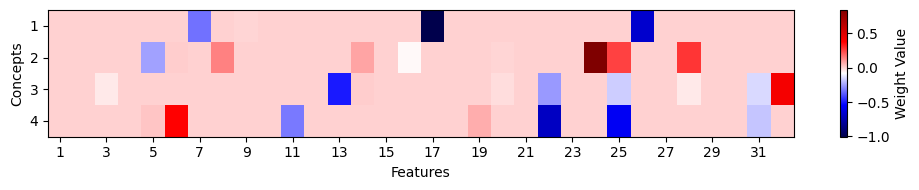

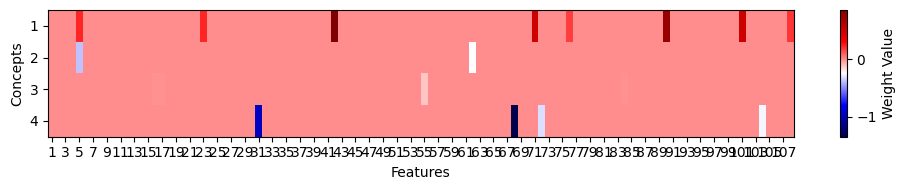

In [33]:
def plot(wwww):
    plt.figure(figsize=(10, 2))
    plt.imshow(wwww, cmap='seismic', aspect='auto')
    plt.colorbar(label='Weight Value')
    # plt.title('Heatmap Masked Weights')
    plt.xlabel('Features')
    plt.ylabel('Concepts')
    plt.xticks(range(wwww.shape[1])[::2], range(1, wwww.shape[1]+1)[::2])
    plt.yticks(range(wwww.shape[0]), range(1, wwww.shape[0]+1))
    plt.grid(visible=False)
    plt.tight_layout()
    plt.savefig("fig/Heatmap Masked Weights.pdf", format="pdf")
    plt.show()

plot(masked_weights1)
plot(masked_weights2)

In [10]:
concept = 3
selected_feature_names = [MIMIC_long_var_names[i] for i in selected_indices_per_concept[concept]]
idx_to_cnt = [val +1 for val in selected_indices_per_concept[concept]]
df = pd.DataFrame((selected_feature_names, selected_weights_per_concept[concept]), index=["Feature Name", "Weight"], columns=idx_to_cnt).T
df.index.name = "Feature ID"

with open('tex/Concept Features and Weights.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = df.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)


df

IndexError: list index out of range